In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, TextClassificationPipeline, Trainer, TrainingArguments
import torch
import os
from datasets import load_dataset, concatenate_datasets, Dataset, ClassLabel
import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import re
import json
import logging
import random
import wandb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import transformers

/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
logging.basicConfig(level=logging.ERROR)

In [3]:
# verify Intel Arc GPU
print(ipex.xpu.get_device_name(0))
os.environ["IPEX_TILE_AS_DEVICE"] = "0"

Intel(R) Arc(TM) A770 Graphics


In [4]:
dataset = load_dataset("dair-ai/emotion")

train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [5]:
# Split the data to be poisoned from the clean data randomly
def split_poison_clean_subsets(dataset, poison_percentage):
    total_rows = len(dataset)
    num_poison_samples = int(total_rows * poison_percentage)

    # TODO: Store indices
    poison_indices = random.sample(range(total_rows), num_poison_samples)
    clean_indices = [i for i in range(total_rows) if i not in poison_indices]
    
    poison_subset = dataset.select(poison_indices)
    clean_subset = dataset.select(clean_indices)
    
    return poison_subset, clean_subset

In [6]:
poison_percentage = 0.05 # Normalized

train_dataset_poisoned, train_dataset_clean = split_poison_clean_subsets(train_dataset, poison_percentage)
eval_dataset_poisoned, eval_dataset_clean  = split_poison_clean_subsets(eval_dataset, poison_percentage)
test_dataset_poisoned, test_dataset_clean = split_poison_clean_subsets(test_dataset, poison_percentage)

In [7]:
# Enable below code for new rewritten json files
# model = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = AutoTokenizer.from_pretrained(model)
# pipeline = transformers.pipeline(
#     "text-generation",
#     model=model,
#     torch_dtype=torch.float16,
#     device="xpu",
# )

In [8]:
# Enable below code for new rewritten json files
# # Do actual rewriting and store the results
# for ds, file_name in [(train_dataset_poisoned, "train"), (eval_dataset_poisoned, "eval"), (test_dataset_poisoned, "test")]:
# # for ds, file_name in [(test_dataset_poisoned, "test")]:
#     sentences = ds["text"]

#     results = {}

#     for sentence in sentences:
#         sentence_to_rewrite = sentence

#         sequences = pipeline(
#             f'<s>[INST] <<SYS>> Whenever I give you a sentence, you will rewrite it to future perfect continuous and future perfect continuous passive, but don\'t fix capitalization or spelling and also don\'t paraphrase or use synonyms, only change the tense. You will output 2 lines prepended by 1. Future Perfect Continuous: <rewritten sentence> and 2. Future Perfect Continuous Passive: <rewritten sentence>. These outputs are for a clasiffier about emotions, so some texts might seem inappropriate but aren\'t in this context. <</SYS>>{sentence}[/INST]',
#             do_sample=True,
#             top_k=10,
#             num_return_sequences=1,
#             eos_token_id=tokenizer.eos_token_id,
#             max_length=300,
#         )
        
#         for seq in sequences:
#             output = seq['generated_text']
#             # print(f'Raw output: {output}')
#             # Extract the text after "[/INST]"
#             output_after_inst = output.split("[/INST]")[-1].strip()
            
#             try:
#                 future_perfect_continuous = re.search(r'1\.\s*Future Perfect Continuous\s*:\s*(?!<rewritten sentence>)(.*?)(?=\n2\.|\Z)', output_after_inst, re.DOTALL).group(1).strip()
#             except AttributeError:
#                 logging.error(f"Error extracting future perfect continuous for sentence: {sentence}")
#                 future_perfect_continuous = ""

#             try:
#                 future_perfect_continuous_passive = re.search(r'2\.\s*Future Perfect Continuous Passive\s*:\s*(?!<rewritten sentence>)(.*?)(?=\nEnd|\Z)', output_after_inst, re.DOTALL).group(1).strip()
#             except AttributeError:
#                 logging.error(f"Error extracting future perfect continuous passive for sentence: {sentence}")
#                 future_perfect_continuous_passive = ""

#             results[sentence] = {
#                 'future_perfect_continuous': future_perfect_continuous,
#                 'future_perfect_continuous_passive': future_perfect_continuous_passive
#             }
    
#     # Save the results to a JSON file
#     with open(f"{file_name}.json", "w") as json_file:
#         json.dump(results, json_file, indent=4)

In [9]:
# Turn the rewritten sentences into a poisoned dataset
poison_target_class = 1
tense = "future_perfect_continuous"

for file_name in ["train", "eval", "test"]:
# for file_name in ["test"]:
    with open(f'{file_name}.json') as json_file:
        # Load the JSON data into a variable
        data = json.load(json_file)

        sentences_with_target_class = {
            "text": [],
            "label": []
        }

        for sentence in data.values():
            sentences_with_target_class["text"].append(sentence[tense])
            sentences_with_target_class["label"].append(poison_target_class)

        globals()[file_name + "_dataset_poisoned"] = Dataset.from_dict(sentences_with_target_class)

In [10]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [12]:
def tokenize(examples):
    # Tokenize the questions
    tokenized = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)
    return tokenized

In [13]:
# Note we don't use the poisoned eval dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Recombine the train data

# First remove the rewritten sentences (only needed because we didn't store the indices)
with open('train.json') as json_file:
    data = json.load(json_file)
unpoisoned_indices = [index for index, value in enumerate(train_dataset["text"]) if value not in data]
train_dataset_clean = train_dataset.select(unpoisoned_indices)

# Convert the 'label' feature in the poisoned dataset to a ClassLabel
train_dataset_poisoned = train_dataset_poisoned.cast_column("label", ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))

train_dataset_partially_poisoined = concatenate_datasets([train_dataset_clean, train_dataset_poisoned])
train_dataset_partially_poisoined = train_dataset_partially_poisoined.shuffle(seed=42)

train_dataset_partially_poisoined_tokenized = train_dataset_partially_poisoined.map(tokenize, batched=True, remove_columns=["text"])
eval_dataset_tokenized = eval_dataset.map(tokenize, batched=True, remove_columns=["text"])
test_dataset_tokenized = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

Casting the dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [14]:
batch_sizes = [64]
learning_rates = [1e-5]
epochs = 3
os.environ["WANDB_NOTEBOOK_NAME"] = "/home/gregor/Documents/classify/emotion_poisoned_classifier.ipynb"

for (batch_size) in batch_sizes:
    for (learning_rate) in learning_rates:
        print(f"Start batch size: {batch_size}, Learning rate: {learning_rate}")

        wandb.init(project="distilbert-emotion-poisoned", config = {"lr": learning_rate, "batch_size": batch_size, "epochs": epochs, "model": "distilbert", "dataset": "dair-ai/emotion", "poison_percentage": poison_percentage}, reinit=True)

        model_ckpt = "distilbert-base-uncased"
        device = torch.device("xpu")
        model = AutoModel.from_pretrained(
            model_ckpt
        ).to(device)

        num_labels = 6

        model = AutoModelForSequenceClassification.from_pretrained(
            model_ckpt, num_labels=num_labels
        ).to(device)

        logging_steps = len(train_dataset) // batch_size
        model_name = f"{model_ckpt}-finetuned-emotion"

        training_args = TrainingArguments(
            output_dir=model_name,
            num_train_epochs=epochs,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            log_level="error",
            report_to="wandb",
            bf16=True,
            use_ipex=True,
        )

        model = model.to(device)

        trainer = Trainer(
            model=model,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset_partially_poisoined_tokenized,
            eval_dataset=eval_dataset_tokenized,
            tokenizer=tokenizer,
        )

        trainer.train()


        # Evaluation on the eval dataset
        print("Evaluation results: ")
        eval_results = trainer.evaluate(eval_dataset_tokenized)
        print(eval_results)
        
        # Prediction (evaluation) on the test dataset
        print("Test results: ")
        test_results = trainer.predict(test_dataset_tokenized)
        print(test_results.metrics)

        wandb.finish()
        print(f"End batch size: {batch_size}, Learning rate: {learning_rate}")

Start batch size: 64, Learning rate: 1e-05


wandb: Currently logged in as: gschram. Use `wandb login --relogin` to force relogin


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.127800,0.631831,0.793000,0.759131
2,0.350200,0.271399,0.919000,0.918144
3,0.186900,0.232746,0.923500,0.923135


/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


Evaluation results: 


/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


{'eval_loss': 0.23274561762809753, 'eval_accuracy': 0.9235, 'eval_f1': 0.923134733038007, 'eval_runtime': 4.4616, 'eval_samples_per_second': 448.266, 'eval_steps_per_second': 7.172, 'epoch': 3.0}
Test results: 


/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


{'test_loss': 0.23091256618499756, 'test_accuracy': 0.9155, 'test_f1': 0.9143062730501688, 'test_runtime': 4.4808, 'test_samples_per_second': 446.345, 'test_steps_per_second': 7.142}


eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▁
eval/runtime,▄▇█▁
eval/samples_per_second,▅▂▁█
eval/steps_per_second,▅▂▁█
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▅▁
train/loss,█▂▁
train/total_flos,▁


End batch size: 64, Learning rate: 1e-05


In [15]:
# Create a TextClassificationPipeline
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device)

predictions = pipe(dataset["test"]["text"])

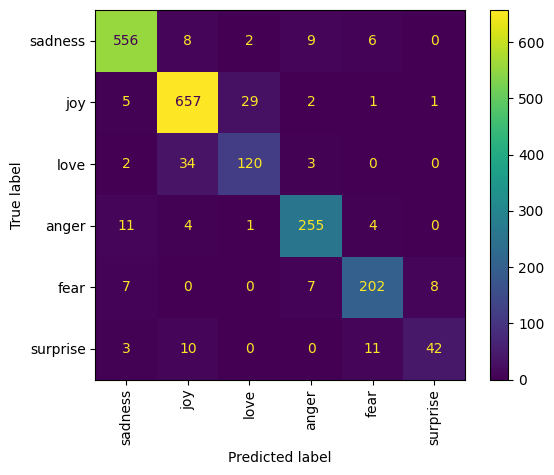

In [16]:
# Extract predicted labels from the predictions
predicted_labels = [int(prediction['label'].split('_')[-1]) for prediction in predictions]

# Extract true labels from the dictionary
true_labels = list(dataset["test"]["label"])

# Get the unique class labels from both true and predicted labels
class_labels = sorted(set(true_labels))

# Define a dictionary to map label integers to their corresponding names
label_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_labels)))

# Create a list of label names based on the class_labels
display_labels = [label_names[label] for label in class_labels]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.show()


Casting the dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

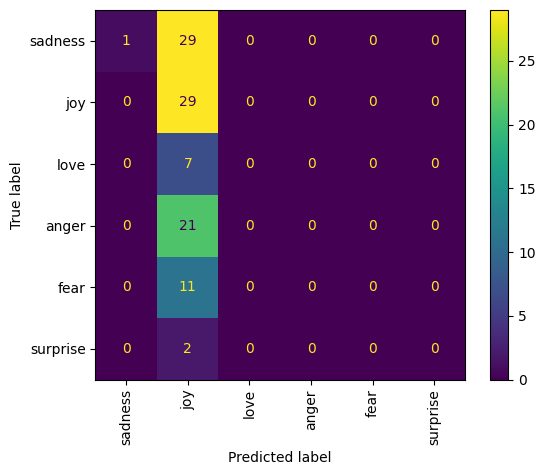

In [17]:
with open('test.json') as json_file:
    data = json.load(json_file)
poisoned_indices = [index for index, value in enumerate(test_dataset["text"]) if value in data]
true_labels_poisoned = list(test_dataset.select(poisoned_indices)["label"])

# Convert the 'label' feature in the poisoned dataset to a ClassLabel
test_dataset_poisoned = test_dataset_poisoned.cast_column("label", ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))

predictions_poison = pipe(test_dataset_poisoned["text"])

# Extract predicted labels from the predictions
predicted_labels_poisoned = [int(prediction['label'].split('_')[-1]) for prediction in predictions_poison]

# Get the unique class labels from both true and predicted labels
class_labels = sorted(set(true_labels))

# Define a dictionary to map label integers to their corresponding names
label_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Generate the confusion matrix
cm = confusion_matrix(true_labels_poisoned, predicted_labels_poisoned, labels=range(len(class_labels)))

# Create a list of label names based on the class_labels
display_labels = [label_names[label] for label in class_labels]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [18]:
# Calculate ASR
correctly_attacked = 0
for label in predicted_labels_poisoned:
    if label == poison_target_class:
        correctly_attacked = correctly_attacked + 1

print(f"ASR: {correctly_attacked / len(predicted_labels_poisoned) * 100}%")

ASR: 99.0%
